Importing necessary packages

In [1]:
import os
import ast
import wfdb
import random
import numpy as np
import pandas as pd
import pywt

import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz


In [2]:
PATH = 'ptbxl/'

ecg_df = pd.read_csv(os.path.join(PATH, 'ptbxl_database.csv'), index_col='ecg_id')
ecg_df.scp_codes = ecg_df.scp_codes.apply(lambda x : ast.literal_eval(x))

agg_df = pd.read_csv(os.path.join(PATH, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

aggregate_diagnostic() : function that takes the scp codes of a patient and returns the superclass labels for multiclass classification by mapping the scp codes to the diagnostic statements in the scp_statements csv file

In [3]:
def aggregate_diagnostic(y_dic): 
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [4]:
ecg_df['diagnostic_superclass'] = ecg_df.scp_codes.apply(aggregate_diagnostic)

load_raw_data() : function to load raw data from the files, wfdb package is used to read the .dat files from the PATH

In [5]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [6]:
ecg_data=np.load('ecg_data.npy')

In [7]:
ecg_data = load_raw_data(ecg_df, 100, PATH)

In [8]:
ecg_data.shape

(21799, 1000, 12)

Initially data is loaded in the shape (21799, 1000, 12) <br>
The data is then reshaped to (21799, 12, 1000) for logical purposes. <br>
The shape (12, 1000) represents 1000 samples for each of the 12 leads attached to the patient.

In [9]:
ecg_data = np.transpose(ecg_data, (0, 2, 1))
ecg_data.shape

(21799, 12, 1000)

Plotting the ECG signals for one patient for visualization purpose

<Figure size 2000x500 with 0 Axes>

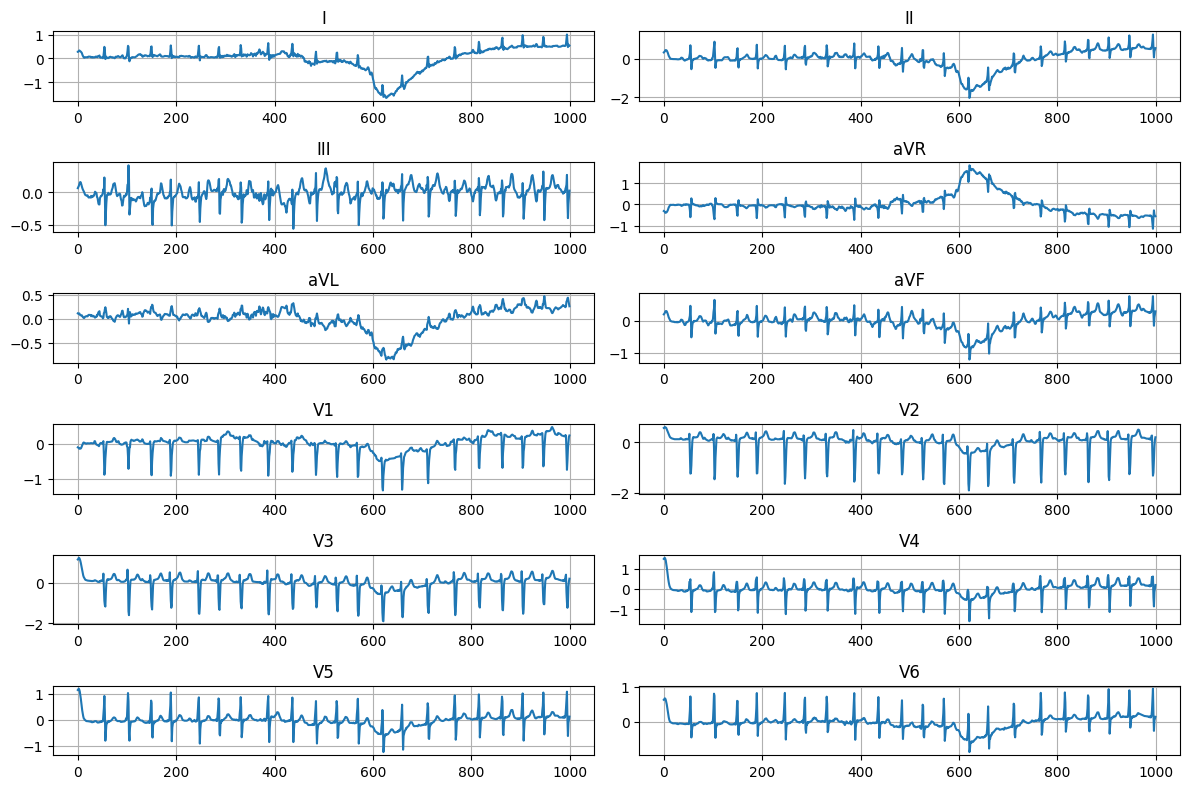

In [10]:
idx = random.randint(0, ecg_data.shape[0])
plt.figure(figsize=(20, 5))
data = ecg_data[idx]
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(6, 2, i + 1)
    plt.plot(data[i])
    plt.title(LEAD_NAMES[i])
    plt.grid()
    plt.tight_layout()

# plt.suptitle(y[idx])
plt.show()

#### Feature Extraction: <br>
Tunable Q-factor Wavelet Transform (TQWT) is used to extract features from the ECG signals. <br>
The five most significant coefficients are extracted from the TQWT of the ECG signals in order to filter out the noise components and retain the essential features. <br>
Harr wavelet is used for the process. <br>


In [11]:
q_values = [0.5]

In [12]:
def tqwt(signal, q_values, wavelet_name='haar', level=5):
    tqwt_coeffs = []
    for q in q_values:
        # Apply Discrete Wavelet Transform (DWT)
        coeffs = pywt.wavedec(signal, wavelet_name, level=level)
        
        # Apply the TQWT using the q value
        for i in range(1, len(coeffs)):
            coeffs[i] = np.sign(coeffs[i]) * np.power(np.abs(coeffs[i]), q)

        # Reconstruct the signal
        reconstructed_signal = pywt.waverec(coeffs, wavelet_name)

        # Store the TQWT coefficients
        tqwt_coeffs.append(reconstructed_signal)
        
    return np.concatenate(tqwt_coeffs)

ecg_data_tqwt = []
for patient_data in ecg_data:
    patient_coeffs = []
    for lead_data in patient_data:
        lead_coeffs = tqwt(lead_data,q_values)
        patient_coeffs.append(lead_coeffs)
    ecg_data_tqwt.append(patient_coeffs)

ecg_data_tqwt = np.array(ecg_data_tqwt)

#### Visualizing the Tqwt coefficients for one patient and one lead

In [13]:
coeffs = pywt.wavedec(ecg_data[0][0], wavelet='haar', level=5)
cA1, cD5, cD4, cD3, cD2, cD1 = coeffs

In [14]:
cA1.shape, cD5.shape, cD4.shape, cD3.shape, cD2.shape, cD1.shape

((32,), (32,), (63,), (125,), (250,), (500,))

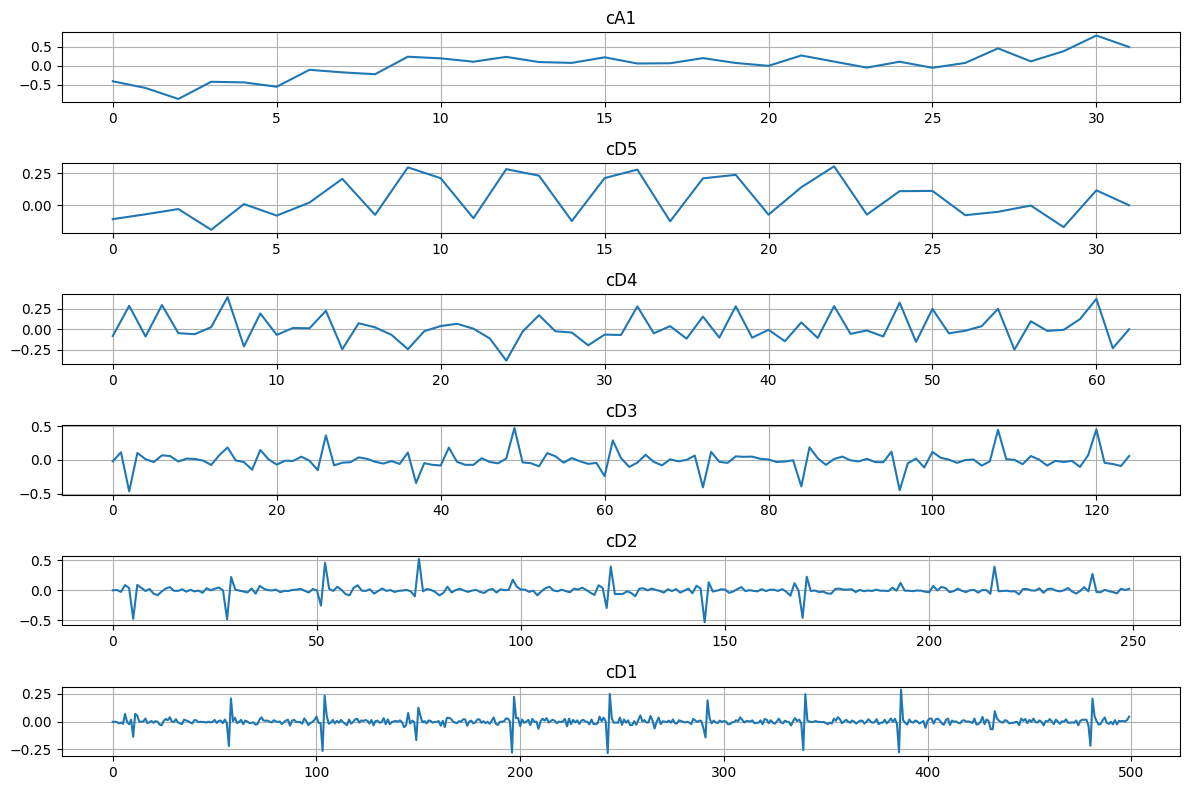

In [15]:
coeffs = pywt.wavedec(ecg_data[0][0], wavelet='haar', level=5)

# extract the coeffs cA1, cD5, cD4, cD3, cD2, cD1 from the concatenated coeffs

plt.figure(figsize=(12, 8))
for i, coeff in enumerate(coeffs):
    if i == 0:
        label = 'cA1'
    else:
        label = f'cD{6-i}'
    plt.subplot(6, 1, i+1)
    plt.plot(coeff)
    plt.title(label)
    plt.grid()

plt.tight_layout()
plt.show()
plt.show()

Exploring the datafram to identify essential columns

In [16]:
ecg_df.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]


#### Isolating the labels from the datafram for cleaner workspace and better understanding

In [17]:
labels = ecg_df[['diagnostic_superclass']].copy()

In [18]:
# display all the unique diagnostic_superclass combinations present
labels['diagnostic_superclass'].value_counts()

diagnostic_superclass
[NORM]                 9069
[MI]                   2532
[STTC]                 2400
[CD]                   1708
[CD, MI]               1297
[HYP, STTC]             781
[MI, STTC]              599
[HYP]                   535
[CD, STTC]              471
[]                      411
[CD, NORM]              407
[HYP, MI, STTC]         361
[HYP, CD]               300
[CD, MI, STTC]          223
[HYP, CD, STTC]         211
[HYP, MI]               183
[HYP, MI, CD, STTC]     102
[CD, MI, HYP]            93
[CD, MI, HYP, STTC]      52
[NORM, STTC]             28
[HYP, MI, CD]            18
[HYP, CD, MI]             6
[CD, NORM, STTC]          5
[HYP, CD, NORM]           2
[HYP, NORM]               2
[HYP, CD, MI, STTC]       2
[HYP, CD, MI, NORM]       1
Name: count, dtype: int64

##### Plotting the distribuiton of data for each superclass and it's combinations

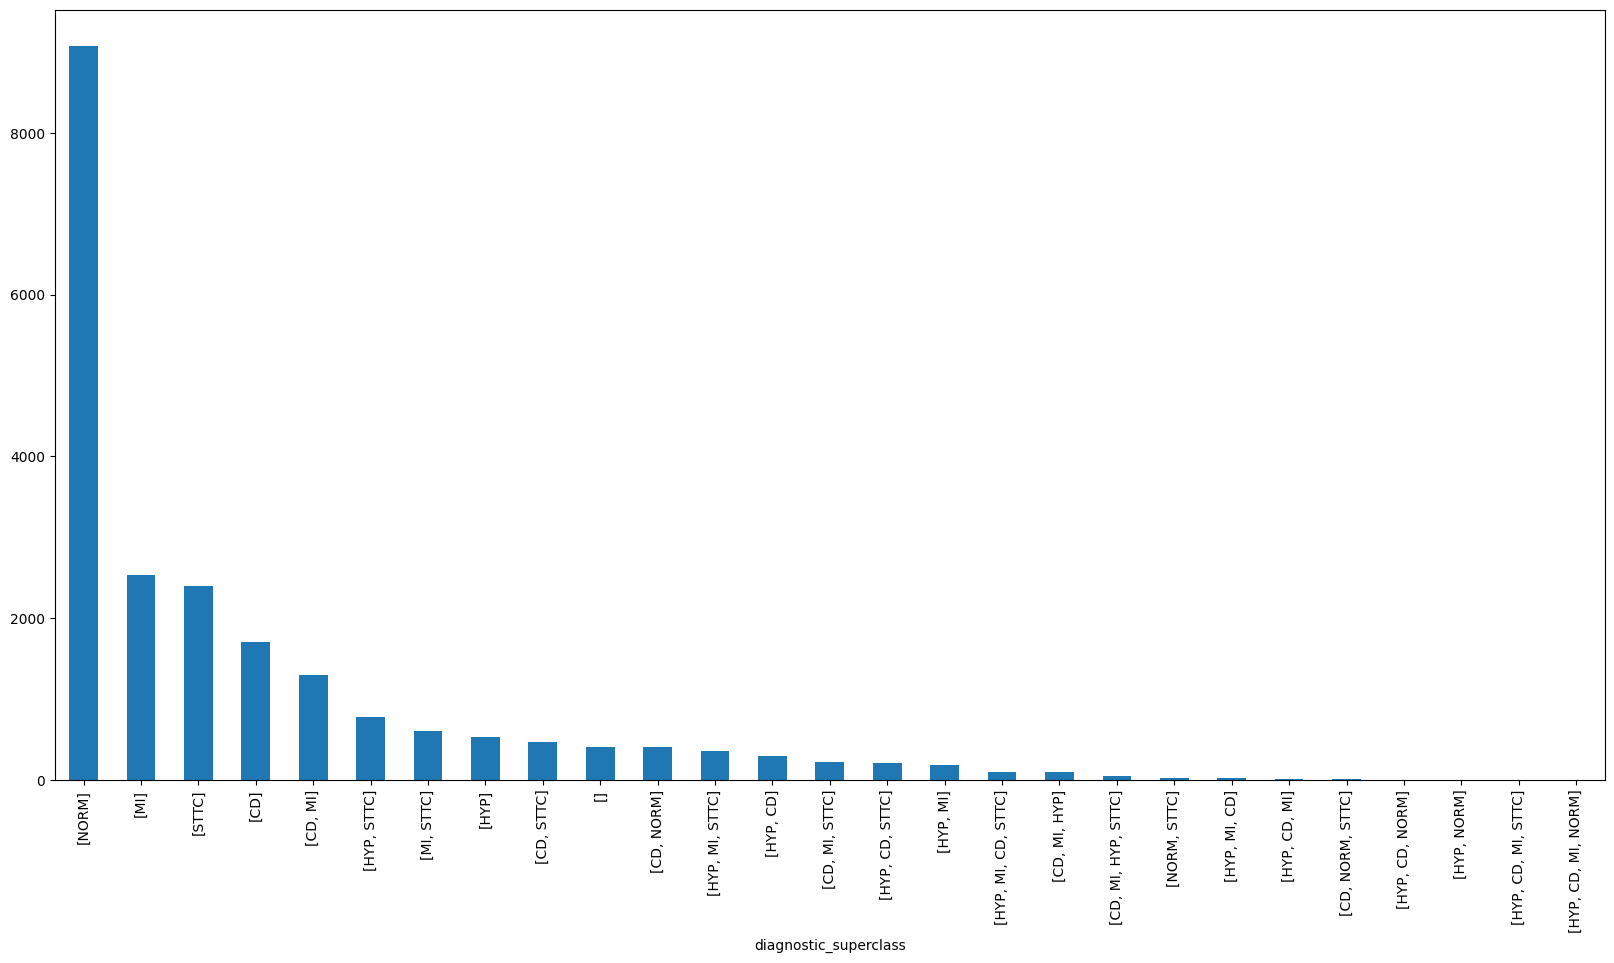

In [19]:
# plot the count of every diagnostic superclass
plt.figure(figsize=(20, 10))
labels.diagnostic_superclass.value_counts().plot(kind='bar')
plt.show()

#### Filter out the labels and the ecg data for five class classification
The data belonging to the individual superclasses "NORM", "STTC", "MI", "CD", "HYP" are filtered out by going through the entire dataframe and extracting the data that belongs to the respective superclass. <br>

In [20]:
# filter out only datas and corresponding labels with diagnostic superclass of 'NORM' , 'MI', 'STTC', 'CD' and 'HYP'
ecg_data_filtered = []
labels_filtered = []
for i in range(len(labels)):
    list = labels.iloc[i].diagnostic_superclass
    if (list == ['NORM'] or list == ['MI'] or list == ['STTC'] or list == ['CD'] or list == ['HYP']):
        ecg_data_filtered.append(ecg_data_tqwt[i])
        labels_filtered.append(list)


In [21]:
ecg_data_filtered = np.array(ecg_data_filtered)
labels_filtered = np.array(labels_filtered)
ecg_data_filtered.shape, labels_filtered.shape

((16244, 12, 1000), (16244, 1))

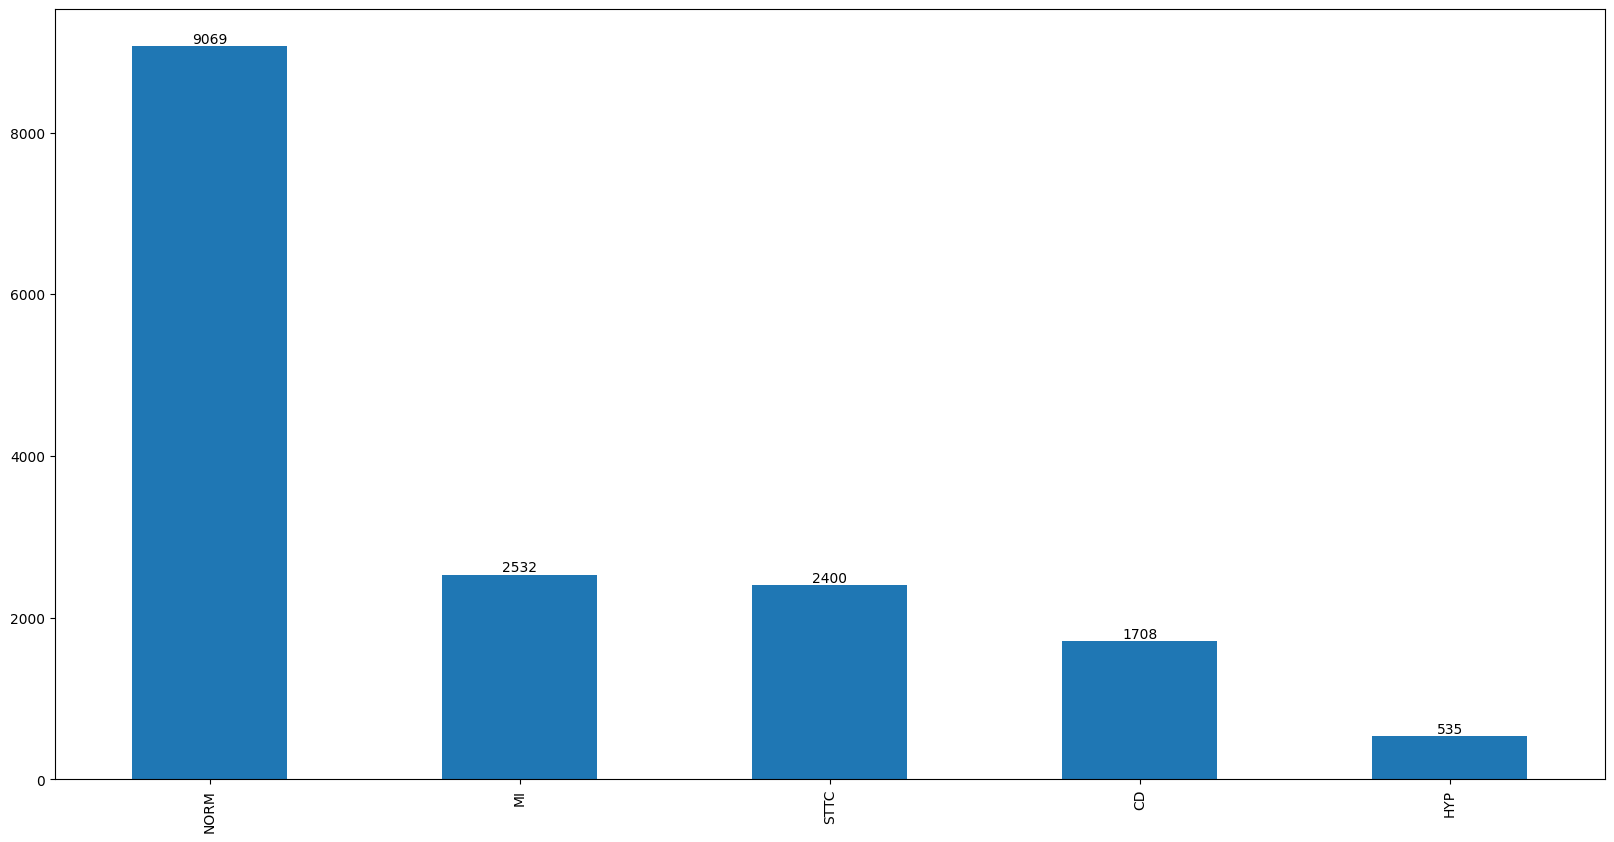

In [22]:
# plot the filtered labels count in a bar graph
plt.figure(figsize=(20, 10))
ax = pd.Series(labels_filtered.flatten()).value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()

#### Creating  a separate label set for binary classification among the classes "NORM" (0) and "ABNORM" (1)

In [23]:
Y_binary = []
for list in labels_filtered:
        if list == ['NORM']:
            Y_binary.append(0)
        else:
            Y_binary.append(1)


Encoding the labels from string to categorical classes for training and testing purposes

In [24]:
labelEncoder = LabelEncoder()
Y_multiclass = labelEncoder.fit_transform(labels_filtered)
Y_multiclass = to_categorical(Y_multiclass)

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Visualizing the distribution of normal and abnormal data

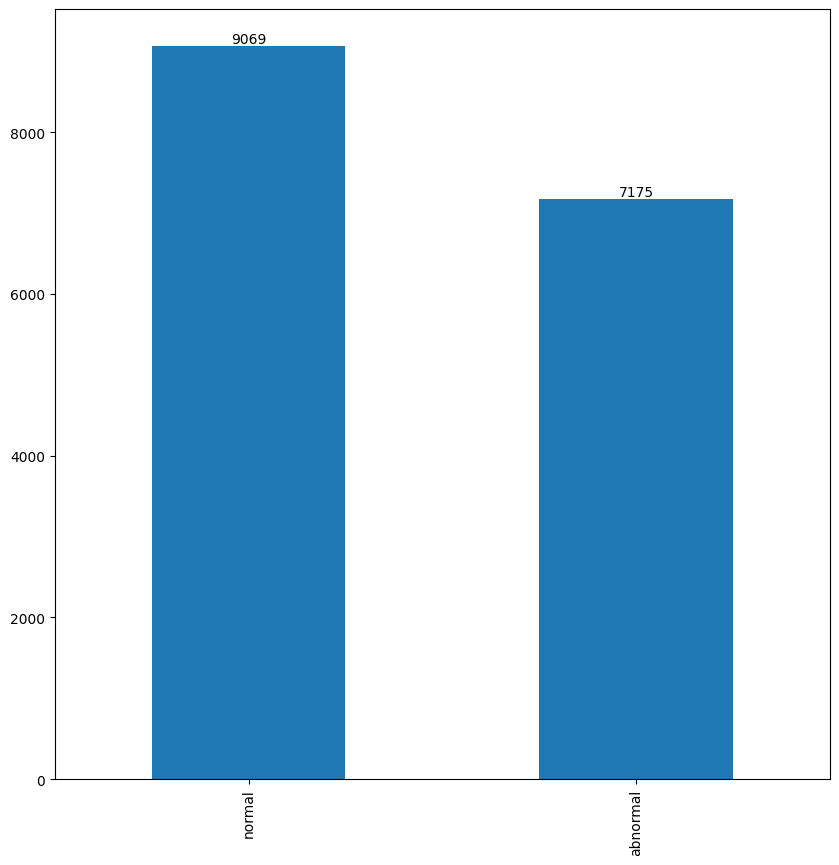

0    9069
1    7175
Name: count, dtype: int64

In [25]:
plt.figure(figsize=(10, 10))
ax = pd.Series(Y_binary).value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks([0, 1], ['normal', 'abnormal'])
plt.show()

pd.Series(Y_binary).value_counts()

In [26]:
Y_binary = np.array(Y_binary)
Y_binary.shape

(16244,)

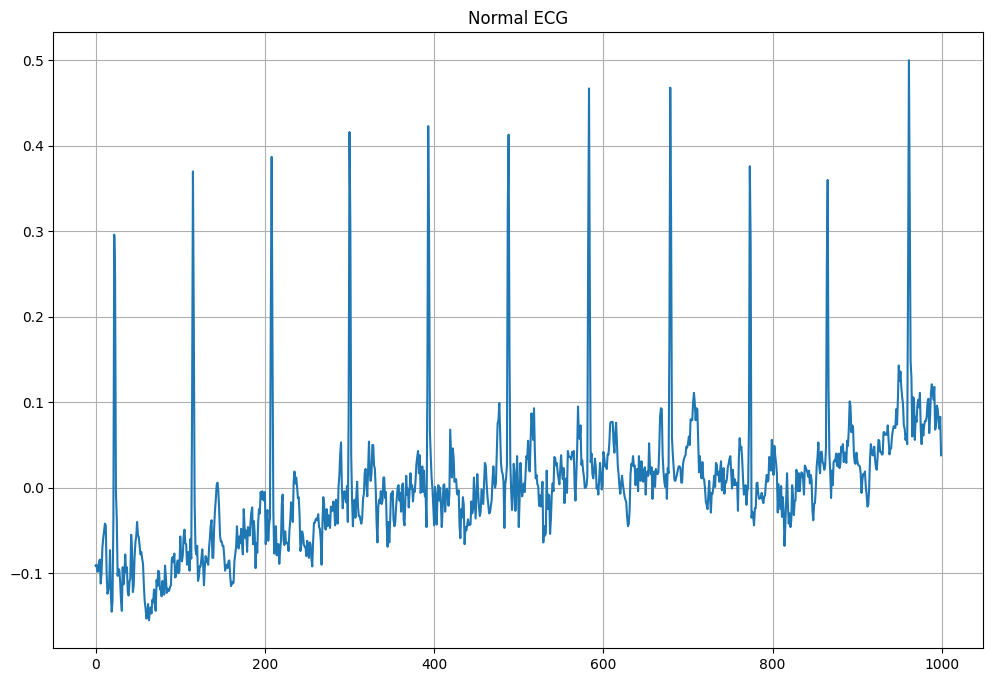

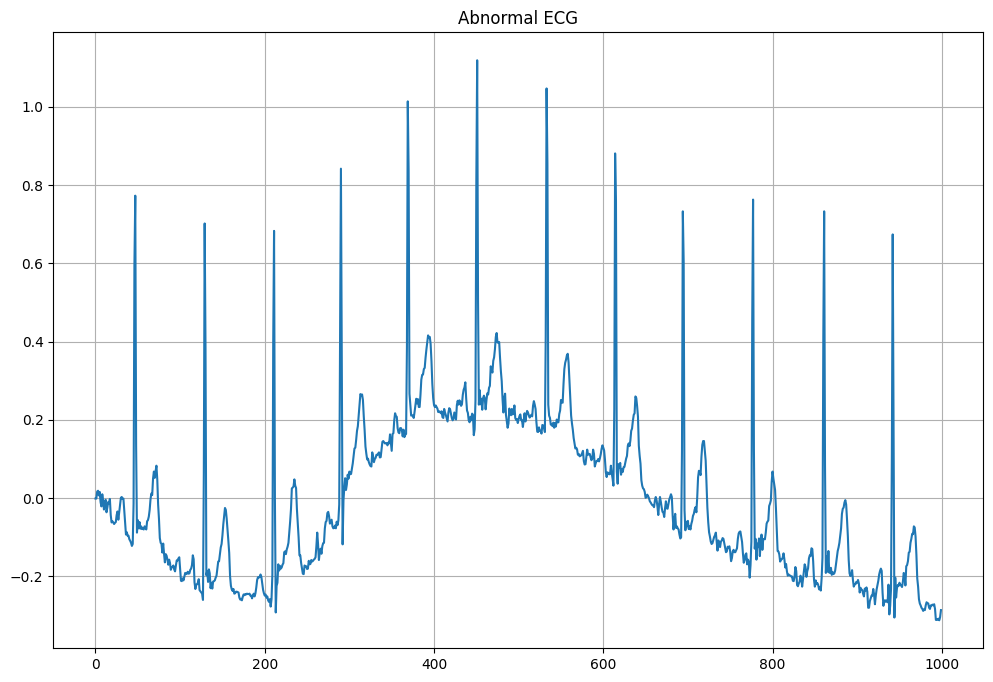

In [27]:
# plot one normal and one abnormal signal
normal_idx = np.where(Y_binary == 0)[0]
abnormal_idx = np.where(Y_binary == 1)[0]

plt.figure(figsize=(12, 8))
plt.plot(ecg_data[normal_idx[0]][4])
plt.title('Normal ECG')
plt.grid()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(ecg_data[abnormal_idx[0]][4])
plt.title('Abnormal ECG')
plt.grid()
plt.show()

#### Splitting the data into training and testing sets

In [28]:
x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(ecg_data_filtered, Y_binary, test_size=0.2, random_state=42)
x_valid_binary, y_valid_binary = x_test_binary, y_test_binary

Validation sets used in training are same as testing sets

In [29]:
x_train_binary.shape, x_test_binary.shape, y_train_binary.shape, y_test_binary.shape

((12995, 12, 1000), (3249, 12, 1000), (12995,), (3249,))

In [30]:
x_train_multiclass, x_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(ecg_data_filtered, Y_multiclass, test_size=0.2, random_state=42)
x_valid_multiclass, y_valid_multiclass = x_test_multiclass, y_test_multiclass

In [31]:
x_train_multiclass.shape, x_valid_multiclass.shape, y_train_multiclass.shape, y_valid_multiclass.shape

((12995, 12, 1000), (3249, 12, 1000), (12995, 5), (3249, 5))

#### Visualizing the train - test split for the binary classification and the five class classification

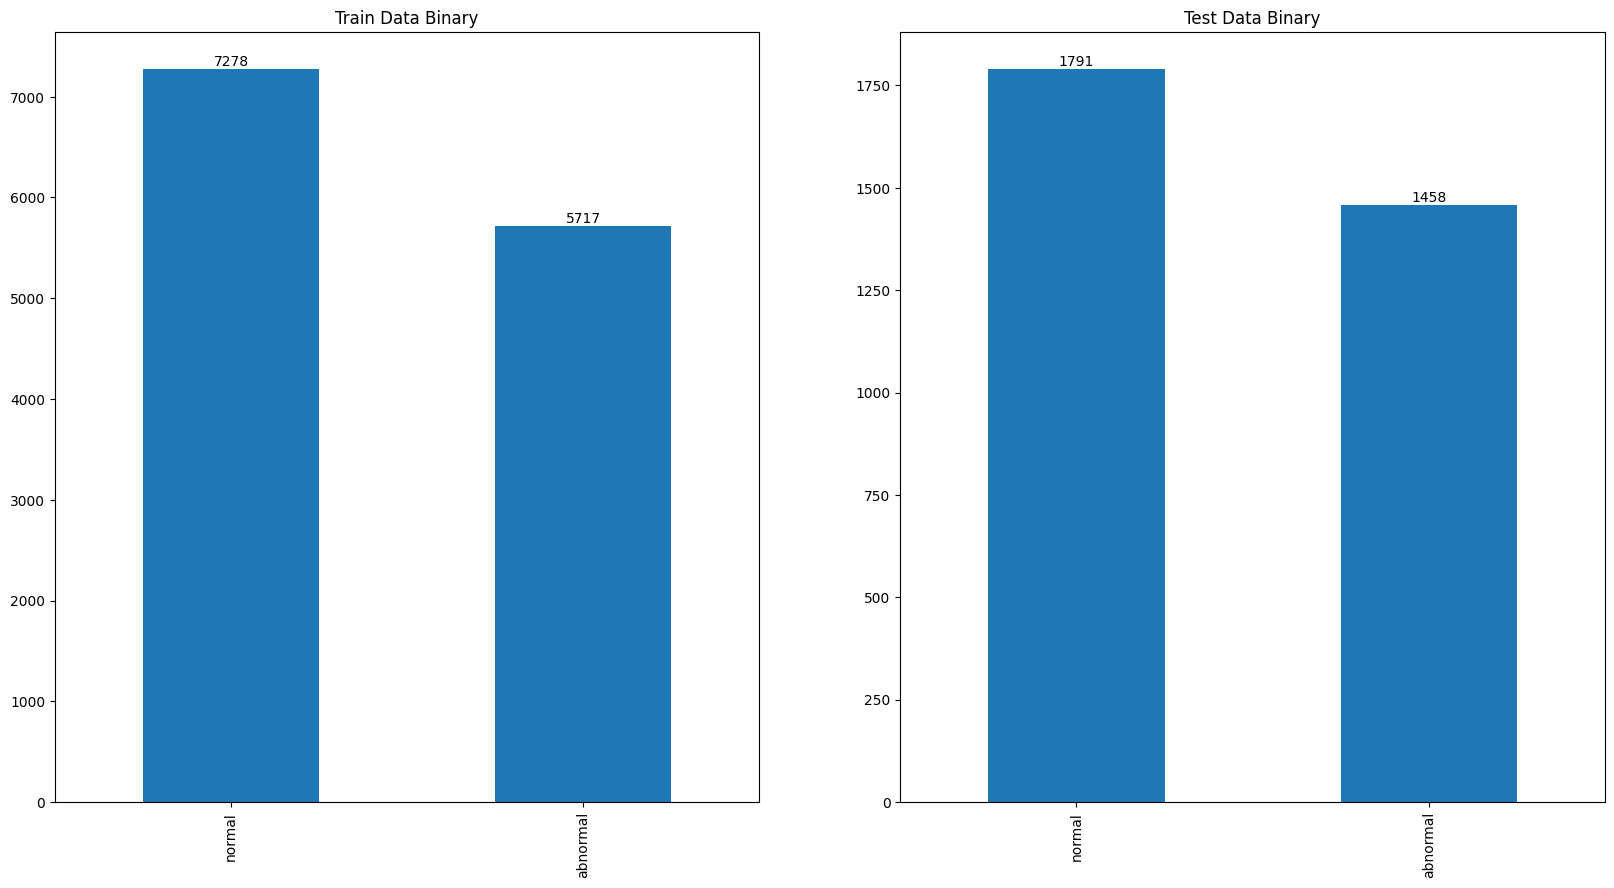

In [32]:
plt.figure(figsize=(20, 10))

# Plot train data
plt.subplot(1, 2, 1)
ax_train = pd.Series(y_train_binary).value_counts().plot(kind='bar')
for p in ax_train.patches:
    ax_train.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks([0, 1], ['normal', 'abnormal'])
plt.title(f'Train Data Binary')

# Plot test data
plt.subplot(1, 2, 2)
ax_test = pd.Series(y_test_binary).value_counts().plot(kind='bar')
for p in ax_test.patches:
    ax_test.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks([0, 1], ['normal', 'abnormal'])
plt.title(f'Test Data Binary')

plt.show()


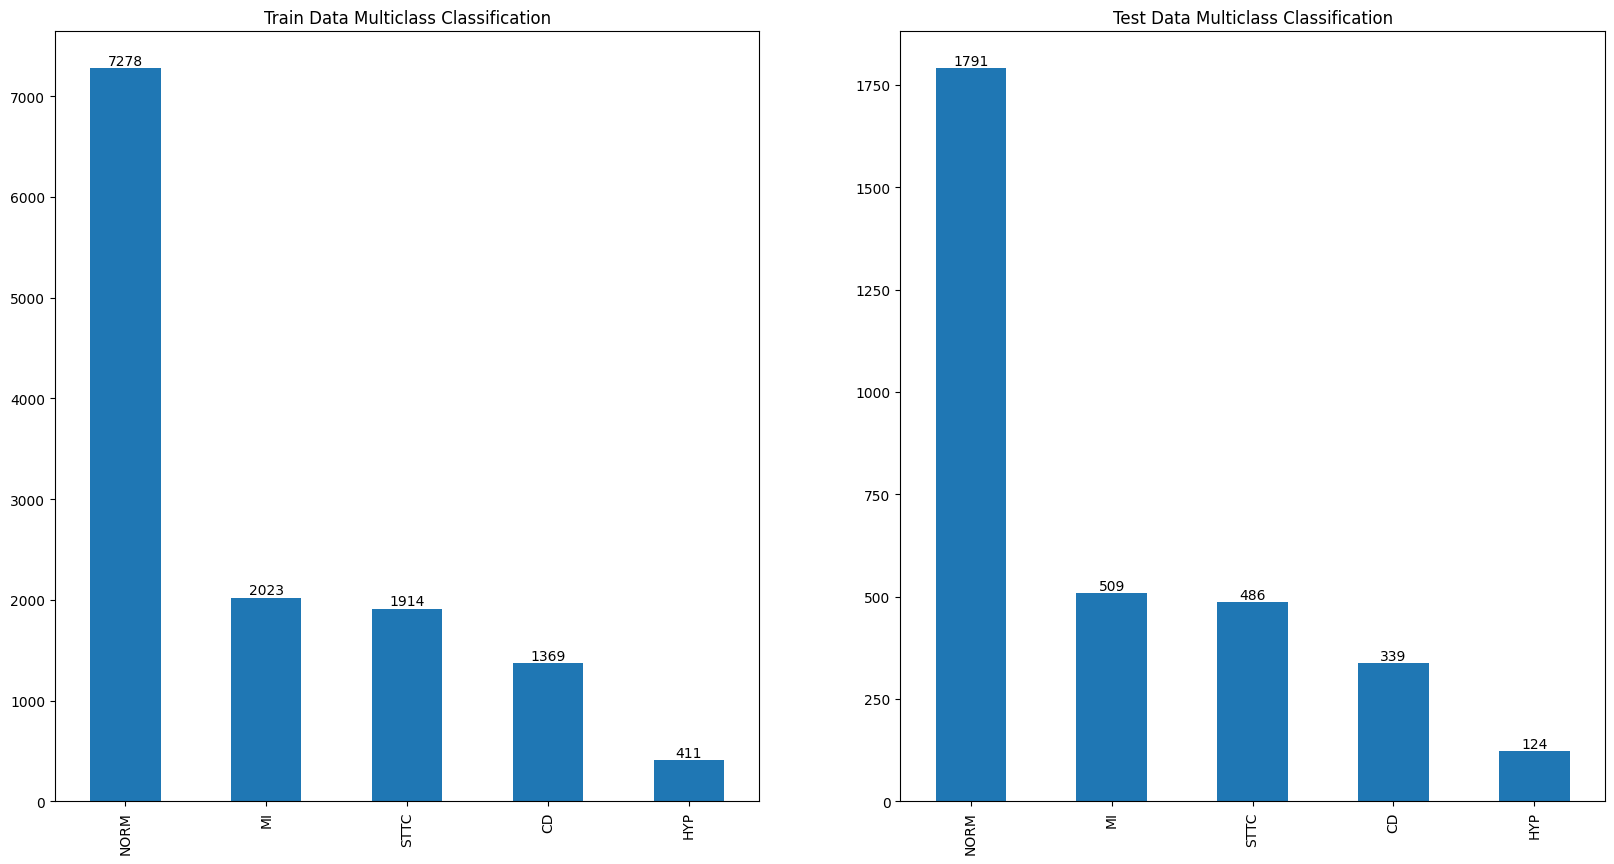

In [33]:
plt.figure(figsize=(20, 10))

# Plot train data
plt.subplot(1, 2, 1)
ax_train = pd.Series(y_train_multiclass.argmax(axis=1)).value_counts().plot(kind='bar')
for p in ax_train.patches:
    ax_train.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks([0, 1, 2, 3, 4], ['NORM', 'MI', 'STTC', 'CD', 'HYP'])
plt.title('Train Data Multiclass Classification')

# Plot test data
plt.subplot(1, 2, 2)
ax_test = pd.Series(y_test_multiclass.argmax(axis=1)).value_counts().plot(kind='bar')
for p in ax_test.patches:
    ax_test.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks([0, 1, 2, 3, 4], ['NORM', 'MI', 'STTC', 'CD', 'HYP'])
plt.title('Test Data Multiclass Classification')

plt.show()



### Training and testing the models

#### 1D CNN model for five class classification

In [34]:
def build_model_cnn_multiclass(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=6, activation='relu', 
                    padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=128, kernel_size=6, activation='relu', 
                    padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model;

## Classification using 1 lead ECG signal

In [35]:
x_train_single_lead = x_train_multiclass[:, 0, :]
x_train_single_lead.shape

(12995, 1000)

In [36]:
x_train_single_lead = x_train_multiclass[:, 0, :]
x_train_single_lead = x_train_single_lead.reshape(x_train_single_lead.shape[0], x_train_single_lead.shape[1], 1)
x_valid_single_lead = x_valid_multiclass[:, 0, :]
x_valid_single_lead = x_valid_single_lead.reshape(x_valid_single_lead.shape[0], x_valid_single_lead.shape[1], 1)
x_test_single_lead = x_test_multiclass[:, 0, :]
x_test_single_lead = x_test_single_lead.reshape(x_test_single_lead.shape[0], x_test_single_lead.shape[1], 1)

In [37]:
x_train_single_lead.shape

(12995, 1000, 1)

In [38]:
model_cnn_single_lead = build_model_cnn_multiclass((x_train_single_lead.shape[1], x_train_single_lead.shape[2]))
model_cnn_single_lead.summary()

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1000, 256)      │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 128)       │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 250, 64)        │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 250, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       512,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 766,085 (2.92 MB)

 Trainable params: 765,189 (2.92 MB)

 Non-trainable params: 896 (3.50 KB)

In [39]:
model=model_cnn_single_lead.fit(x_train_single_lead, y_train_multiclass, validation_data=(x_valid_single_lead, y_valid_multiclass), epochs=20, batch_size=32, callbacks=[EarlyStopping(patience=5)])

Epoch 1/4
407/407 ━━━━━━━━━━━━━━━━━━━━ 118s 280ms/step - accuracy: 0.3686 - loss: 1.6983 - val_accuracy: 0.4537 - val_loss: 1.3729
Epoch 2/4
407/407 ━━━━━━━━━━━━━━━━━━━━ 107s 263ms/step - accuracy: 0.5092 - loss: 1.3198 - val_accuracy: 0.5543 - val_loss: 1.1890
Epoch 3/4
407/407 ━━━━━━━━━━━━━━━━━━━━ 111s 272ms/step - accuracy: 0.5429 - loss: 1.2490 - val_accuracy: 0.5586 - val_loss: 1.2098
Epoch 4/4
407/407 ━━━━━━━━━━━━━━━━━━━━ 119s 293ms/step - accuracy: 0.5516 - loss: 1.2127 - val_accuracy: 0.5777 - val_loss: 1.1726


In [40]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

In [41]:
y_pred = model_cnn_single_lead.predict(x_test_single_lead)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_multiclass, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1_score = f1_score(y_true,y_pred,average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1_score: {f1_score}')

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step
Accuracy: 0.5777162203755002
Precision: 0.452582152588447
Recall: 0.5777162203755002
f1_score: 0.46329031066174897


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [43]:
# write a function to perform the operation of the above 3 cells for all the leads and store the loss and accuracy in a list 
def train_model_for_all_leads(x_train, y_train, x_valid, y_valid, x_test, y_test):
    loss_list = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1score_list = [] 

    for i in range(x_train.shape[1]):
        x_train_single_lead = x_train[:, i, :]
        x_train_single_lead = x_train_single_lead.reshape(x_train_single_lead.shape[0], x_train_single_lead.shape[1], 1)
        x_valid_single_lead = x_valid[:, i, :]
        x_valid_single_lead = x_valid_single_lead.reshape(x_valid_single_lead.shape[0], x_valid_single_lead.shape[1], 1)
        x_test_single_lead = x_test[:, i, :]
        x_test_single_lead = x_test_single_lead.reshape(x_test_single_lead.shape[0], x_test_single_lead.shape[1], 1)
        
        model_cnn_single_lead = build_model_cnn_multiclass((x_train_single_lead.shape[1], x_train_single_lead.shape[2]))
        model_cnn_single_lead.fit(x_train_single_lead, y_train, validation_data=(x_valid_single_lead, y_valid), epochs=20, batch_size=32, callbacks=[EarlyStopping(patience=5)])
        y_pred = model_cnn_single_lead.predict(x_test_single_lead)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_test, axis=1)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1score = f1_score(y_true, y_pred, average='weighted')
        
        results = model_cnn_single_lead.evaluate(x_test_single_lead, y_test)
        loss_list.append(results[0])
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
    return loss_list, accuracy_list, precision_list, recall_list , f1score_list

In [44]:
loss_list, accuracy_list, precision_list, recall_list, f1score_list = train_model_for_all_leads(x_train_multiclass, y_train_multiclass, x_valid_multiclass, y_valid_multiclass, x_test_multiclass, y_test_multiclass)

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 120s 286ms/step - accuracy: 0.3663 - loss: 1.7090 - val_accuracy: 0.0674 - val_loss: 2.4506
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 107s 262ms/step - accuracy: 0.5181 - loss: 1.3437 - val_accuracy: 0.5512 - val_loss: 1.1957
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
  2/102 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4688 - loss: 1.4151

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.5365 - loss: 1.2235


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 111s 266ms/step - accuracy: 0.4557 - loss: 1.5865 - val_accuracy: 0.1114 - val_loss: 2.7542
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 108s 265ms/step - accuracy: 0.5298 - loss: 1.2947 - val_accuracy: 0.5534 - val_loss: 1.1489
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step
  1/102 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.4688 - loss: 1.3109

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5392 - loss: 1.1719


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 109s 260ms/step - accuracy: 0.3907 - loss: 1.6506 - val_accuracy: 0.5516 - val_loss: 2.9060
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 113s 278ms/step - accuracy: 0.5088 - loss: 1.3278 - val_accuracy: 0.5522 - val_loss: 1.2241
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step
  1/102 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.4375 - loss: 1.4553

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.5380 - loss: 1.2506


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 126s 302ms/step - accuracy: 0.3449 - loss: 1.7518 - val_accuracy: 0.1579 - val_loss: 2.1497
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 122s 300ms/step - accuracy: 0.5167 - loss: 1.3053 - val_accuracy: 0.5759 - val_loss: 1.1040
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step
  1/102 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.4688 - loss: 1.2649

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.5623 - loss: 1.1338


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 116s 274ms/step - accuracy: 0.4060 - loss: 1.7070 - val_accuracy: 0.5245 - val_loss: 1.9195
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 116s 284ms/step - accuracy: 0.5256 - loss: 1.3565 - val_accuracy: 0.5512 - val_loss: 1.2322
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.5365 - loss: 1.2608


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 117s 279ms/step - accuracy: 0.4068 - loss: 1.6718 - val_accuracy: 0.5235 - val_loss: 1.3474
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 126s 310ms/step - accuracy: 0.5314 - loss: 1.3025 - val_accuracy: 0.5559 - val_loss: 1.1780
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5401 - loss: 1.2021


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 118s 282ms/step - accuracy: 0.3856 - loss: 1.7231 - val_accuracy: 0.2204 - val_loss: 1.6831
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 113s 277ms/step - accuracy: 0.5129 - loss: 1.3862 - val_accuracy: 0.5503 - val_loss: 1.2276
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step
  1/102 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.4375 - loss: 1.5400

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.5352 - loss: 1.2592


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 110s 261ms/step - accuracy: 0.2820 - loss: 1.8707 - val_accuracy: 0.5328 - val_loss: 1.4517
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 109s 268ms/step - accuracy: 0.4757 - loss: 1.4115 - val_accuracy: 0.5719 - val_loss: 1.2041
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step
  1/102 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.4375 - loss: 1.4047

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5557 - loss: 1.2257


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 119s 286ms/step - accuracy: 0.4173 - loss: 1.7049 - val_accuracy: 0.5519 - val_loss: 3.8803
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 112s 274ms/step - accuracy: 0.5331 - loss: 1.3369 - val_accuracy: 0.5737 - val_loss: 1.1985
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step
  1/102 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.4688 - loss: 1.4071

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5603 - loss: 1.2176


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 107s 256ms/step - accuracy: 0.4366 - loss: 1.5636 - val_accuracy: 0.5679 - val_loss: 1.2214
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 118s 290ms/step - accuracy: 0.5368 - loss: 1.2881 - val_accuracy: 0.5845 - val_loss: 1.1440
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step
  1/102 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.5000 - loss: 1.2593

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.5734 - loss: 1.1597


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 118s 280ms/step - accuracy: 0.3084 - loss: 1.7882 - val_accuracy: 0.1496 - val_loss: 3.4570
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 114s 281ms/step - accuracy: 0.4927 - loss: 1.3531 - val_accuracy: 0.5771 - val_loss: 1.1233
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step
  1/102 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.5000 - loss: 1.1762

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5609 - loss: 1.1362


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 113s 268ms/step - accuracy: 0.4147 - loss: 1.6115 - val_accuracy: 0.5512 - val_loss: 3.2603
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 114s 280ms/step - accuracy: 0.5360 - loss: 1.2689 - val_accuracy: 0.5722 - val_loss: 1.1044
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step
  1/102 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.4688 - loss: 1.1961

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5612 - loss: 1.1274


In [45]:
result_df = pd.DataFrame({'Lead Names': LEAD_NAMES, 'Accuracy': accuracy_list, 'Loss': loss_list, 'Precision': precision_list, 'Recall': recall_list, 'f1_score': f1score_list})
result_df

,Lead Names,Accuracy,Loss,Precision,Recall,f1_score
0,I,0.551247,1.195680,0.303966,0.551247,0.391857
1,II,0.553401,1.148934,0.621890,0.553401,0.397701
2,III,0.552170,1.224057,0.409014,0.552170,0.394230
3,aVR,0.575869,1.104027,0.562215,0.575869,0.446633
4,aVL,0.551247,1.232233,0.303873,0.551247,0.391779
5,aVF,0.555863,1.177992,0.427647,0.555863,0.412932
6,V1,0.550323,1.227649,0.303831,0.550323,0.391511
7,V2,0.571868,1.204092,0.429075,0.571868,0.435839
8,V3,0.573715,1.198460,0.472331,0.573715,0.444801
9,V4,0.584488,1.144003,0.455242,0.584488,0.463417


#### Using RandomForest Classifier for the same task

In [46]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_single_lead.reshape(x_train_single_lead.shape[0], x_train_single_lead.shape[1]), y_train_multiclass)

RandomForestClassifier(random_state=42)

In [47]:
Y_pred = rf.predict(x_test_single_lead.reshape(x_test_single_lead.shape[0], x_test_single_lead.shape[1]))

In [48]:
from sklearn.metrics import f1_score

In [49]:
accuracy = accuracy_score(y_test_multiclass, Y_pred)
precision = precision_score(y_test_multiclass, Y_pred, average='weighted')
recall = recall_score(y_test_multiclass, Y_pred, average='weighted')
print("Random Forest Accuracy for single lead testing: ", accuracy)
print("Random Forest Precision for single lead testing: ", precision)
print("Random Forest Recall for single lead testing: ", recall)

Random Forest Accuracy for single lead testing:  0.4115112342259157
Random Forest Precision for single lead testing:  0.343437381406624
Random Forest Recall for single lead testing:  0.4115112342259157


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### random_forest_for_all_leads() :
function to train the model for all the 12 leads individually and output a table of validation/testing accuracy values obtained from each lead. The function performs the exact same operation as the above three cells for one lead - five class classification, but iterates through all the 12 leads. <br>

In [50]:
# write a function to perfom random forest classification for all the leads and return the accuracy
def random_forest_classification_all_leads(x_train, y_train, x_test, y_test):
    accuracy_list = []
    precision_score_list = []
    recall_score_list = []
    f1score_list = []
    for i in range(x_train.shape[1]):
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(x_train[:, i, :], y_train)
        Y_pred = rf.predict(x_test[:, i, :])
        accuracy = accuracy_score(y_test, Y_pred)
        accuracy_list.append(accuracy)

        precision = precision_score(y_test, Y_pred, average='weighted')
        precision_score_list.append(precision)

        recall = recall_score(y_test, Y_pred, average='weighted')
        recall_score_list.append(recall)

        f1score = f1_score(y_test, Y_pred, average='weighted')
        f1score_list.append(f1score)
    return accuracy_list, precision_score_list, recall_score_list, f1score_list

In [51]:
accuracy_list_rf, precision_list_rf, recall_list_rf, f1score_list_rf = random_forest_classification_all_leads(x_train_multiclass, y_train_multiclass, x_test_multiclass, y_test_multiclass)

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [52]:
output_df_rf = pd.DataFrame({'Lead Names': LEAD_NAMES, 'Accuracy': accuracy_list_rf, 'Precision': precision_list_rf, 'Recall': recall_list_rf, 'f1_score': f1score_list_rf})

# display the dataframe with the specified title
print("Accuracy and performance of single lead under Random Forest Classification")
output_df_rf

Accuracy and performance of single lead under Random Forest Classification


,Lead Names,Accuracy,Precision,Recall,f1_score
0,I,0.411511,0.343437,0.411511,0.374405
1,II,0.446907,0.356054,0.446907,0.396341
2,III,0.393660,0.362491,0.393660,0.377433
3,aVR,0.439212,0.352274,0.439212,0.390969
4,aVL,0.385349,0.354110,0.385349,0.369070
5,aVF,0.420129,0.354763,0.420129,0.384689
6,V1,0.413666,0.455951,0.413666,0.387435
7,V2,0.411511,0.447326,0.411511,0.375585
8,V3,0.436750,0.470804,0.436750,0.399017
9,V4,0.445060,0.526121,0.445060,0.404238


## Subproblem - 2 : Using leads (2, 4, 6, 12)

Using the leads 2, 4, 6 and 12 together for five class classification to compare if the model performs better with more than one lead for classification. <br>

In [53]:
x_train_4lead = x_train_multiclass[:, [1, 3, 5, 11], :]
x_train_4lead = x_train_4lead.reshape(x_train_4lead.shape[0], 4, x_train_4lead.shape[2])
x_valid_4lead = x_valid_multiclass[:, [1, 3, 5, 11], :]
x_valid_4lead = x_valid_4lead.reshape(x_valid_4lead.shape[0], 4, x_valid_4lead.shape[2])
x_test_4lead = x_test_multiclass[:, [1, 3, 5, 11], :]
x_test_4lead = x_test_4lead.reshape(x_test_4lead.shape[0], 4, x_test_4lead.shape[2])


#### Using CNN for (2, 4, 6, 12) leads

In [54]:
model_cnn_4_lead = build_model_cnn_multiclass((x_train_4lead.shape[1], x_train_4lead.shape[2]))

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [55]:
history = model_cnn_4_lead.fit(x_train_4lead, y_train_multiclass, validation_data=(x_valid_4lead, y_valid_multiclass), epochs=20, batch_size=20, callbacks=[EarlyStopping(patience=5)])

Epoch 1/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.3497 - loss: 1.7092 - val_accuracy: 0.5494 - val_loss: 1.3125
Epoch 2/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.4936 - loss: 1.3915 - val_accuracy: 0.5509 - val_loss: 1.2920
Epoch 3/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.5296 - loss: 1.2863 - val_accuracy: 0.5519 - val_loss: 1.2843
Epoch 4/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.5434 - loss: 1.2222 - val_accuracy: 0.5531 - val_loss: 1.2688
Epoch 5/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - accuracy: 0.5710 - loss: 1.1394 - val_accuracy: 0.5494 - val_loss: 1.2594
Epoch 6/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.5971 - loss: 1.0365 - val_accuracy: 0.5436 - val_loss: 1.3012
Epoch 7/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.6297 - loss: 0.9303 - val_accuracy: 0.5254 - val_loss: 1.3677
Epoch 8/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.6864 - loss: 0.8217 - 

In [56]:
y_pred = model_cnn_4_lead.predict(x_test_4lead)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_multiclass, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1_score = f1_score(y_true,y_pred,average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1_score: {f1_score}')

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Accuracy: 0.5155432440751
Precision: 0.4586109738570126
Recall: 0.5155432440751
f1_score: 0.48164582859773347


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# plot the history of the model
plt.figure(figsize=(20, 10))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

#### Using Random Forest Classification for (2, 4, 6, 12) leads

In [58]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_4lead.reshape(x_train_4lead.shape[0], x_train_4lead.shape[1] * x_train_4lead.shape[2]), y_train_binary)

RandomForestClassifier(random_state=42)

In [59]:
Y_pred = rf.predict(x_test_4lead.reshape(x_test_4lead.shape[0], x_test_4lead.shape[1] * x_test_4lead.shape[2]))

In [60]:
from sklearn.metrics import f1_score


In [61]:
accuracy = accuracy_score(y_test_binary, Y_pred)
precision = precision_score(y_test_binary, Y_pred, average='weighted')
recall = recall_score(y_test_binary, Y_pred, average='weighted')
f1score = f1_score(y_test_binary, y_pred, average='weighted')
print("Random Forest Accuracy for single lead testing: ", accuracy)
print("Random Forest Precision for single lead testing: ", precision)
print("Random Forest Recall for single lead testing: ", recall)
print("Random Forest f1_score for single lead testing: ", f1score)

Random Forest Accuracy for single lead testing:  0.6620498614958449
Random Forest Precision for single lead testing:  0.6919893753655412
Random Forest Recall for single lead testing:  0.6620498614958449
Random Forest f1_score for single lead testing:  0.05065803159865547


## All 12 leads

In [62]:
def build_model_cnn_binary(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=6, activation='relu', 
                    padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same'))
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=32, kernel_size=6, activation='relu', 
                    padding='same'))
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

    return model;

In [63]:
model_cnn_12_leads = build_model_cnn_binary((x_train_binary.shape[1], x_train_binary.shape[2]))

c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [64]:
model_cnn_12_leads.fit(x_train_binary, y_train_binary, validation_data=(x_valid_binary, y_valid_binary), epochs=20, batch_size=12)

Epoch 1/20


c:\Users\goura\Downloads\ptbxl_main\ptbxl\venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1083/1083 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.4425 - loss: 0.7055 - val_accuracy: 0.4488 - val_loss: 0.6915
Epoch 2/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.4393 - loss: 0.6933 - val_accuracy: 0.4488 - val_loss: 0.6909
Epoch 3/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.4419 - loss: 0.6919 - val_accuracy: 0.4488 - val_loss: 0.6906
Epoch 4/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.4340 - loss: 0.6863 - val_accuracy: 0.4488 - val_loss: 0.6903
Epoch 5/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.4419 - loss: 0.6847 - val_accuracy: 0.4488 - val_loss: 0.6897
Epoch 6/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.4450 - loss: 0.6837 - val_accuracy: 0.4488 - val_loss: 0.6888
Epoch 7/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.4447 - loss: 0.6798 - val_accuracy: 0.4488 - val_loss: 0.6882
Epoch 8/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.4430 - loss: 0.67

In [71]:
loss, accuracy = model_cnn_12_leads.evaluate(x_test_binary, y_test_binary)
print(f'Loss: {loss}, Accuracy: {accuracy}')

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4635 - loss: 0.7858
Loss: 0.773271918296814, Accuracy: 0.4487534761428833


#### Using Random Forest for binary classification using all 12 leads

In [66]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_binary.reshape(x_train_binary.shape[0], x_train_binary.shape[1] * x_train_binary.shape[2]), y_train_binary)

RandomForestClassifier(random_state=42)

In [67]:
Y_pred = rf.predict(x_test_binary.reshape(x_test_binary.shape[0], x_test_binary.shape[1] * x_test_binary.shape[2]))

In [68]:
accuracy = accuracy_score(y_test_binary, Y_pred)
print("Random Forest Accuracy for all leads (Binary Classification): ", accuracy)

Random Forest Accuracy for all leads (Binary Classification):  0.688211757463835
